# Trajectories analysis 0 (Loading trajectories form idtracker.ai)
This notebook shows how to load data from trajectories of groups extracted with [idtracker.ai](idtracker.ai). If you use this code and/or data generated with [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., Nature Methods, 2019. idtracker.ai: tracking all individuals in small or large collectives of unmarked animals (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**

To load and analyse the trajectories we will be using the python library *trajectorytools*, you can install with `pip install trajectorytools`. If you use it, please cite:

**Heras, F. J. H., Romero-Ferrero, F., Hinz, R. C., & de Polavieja, G. G. (2019). Deep attention networks reveal the rules of collective motion in zebrafish. PLoS computational biology, 15(9), e1007354.**

## Importing necessary python modules for our analysis

In [1]:
import os
import pathlib
from pprint import pprint

import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# trajectorytools needs to be installed. To install, 
# pip install trajectorytools or follow the instructions at
# http://www.github.com/fjhheras/trajectorytools
import trajectorytools as tt
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial
from trajectorytools.constants import dir_of_data

## Set the path to your trajectories_wo_gaps.npy file

idtracker.ai extracts three different types of trajectories:
* ***trajectories.npy***: trajectories with NaN when the individual is crossing with another individual
* ***trajectories_wo_gaps.npy***: trajectories wiht the NaN values of the crossings interpolated. Some parts of the trajectories might still have NaN values if the individual was occluded or not segmented on those frames.
* ***trajectories_wo_identities.npy***: same as trajectories.npy but the columns indices do not correspond to individuals identities. This trajectories are generated when tracking a video with the option "Track without identities".

These trajectoies files can be found in their corresponding subfolders in the *session folder* generated by idtracker.ai. Here we are loading the default trajectories stored in the data folder of this repository.

In [2]:
trajectories_file_path = '../data/trajectories_wo_gaps.npy'

## Loading the raw trajectories as a numpy dictionary

The trajectories files can be loaded using *numpy* as shown in the following cells.

In [3]:
trajectories_dict = np.load(trajectories_file_path, allow_pickle=True).item()

The trajectories files are python dictionaries that include the trajectories as a numpy array of dimemsions (frames, number_of_animals, coordinates). The trajectories are given in pixels of the video frames.

In [4]:
print('Content of the dictionary: {}'.format(list(trajectories_dict.keys())))
trajectories = trajectories_dict['trajectories']
print('Trajectories from {}'.format(trajectories_dict['video_path']))
print('Number of frames', trajectories.shape[0])
print('Number of individuals', trajectories.shape[1])
print('X range:', np.nanmin(trajectories[...,0]), np.nanmax(trajectories[...,0]), 'pixels')
print('Y range:', np.nanmin(trajectories[...,1]), np.nanmax(trajectories[...,1]), 'pixels')
print(trajectories_dict['frames_per_second'], 'frames per second')
print(trajectories_dict['body_length'], 'pixels per animal')

Content of the dictionary: ['trajectories', 'id_probabilities', 'git_commit', 'video_path', 'frames_per_second', 'body_length']
Trajectories from /media/neto/newOntogeny/newOntogeny/N4/30dpf/second/TU20190305/trial8/video_04-04-19_16-46-06.000.avi
Number of frames 28819
Number of individuals 4
X range: 204.73468910705935 3370.752732240437 pixels
Y range: 162.53184330689737 3356.069838619922 pixels
32 frames per second
69.0 pixels per animal


## Loading the trajectories with the *trajectorytools module*

In the *trajectorytools* module the trajectories can be loaded directly from the idtracker.ai output file or from a numpy array. When loaded from a numpy array the dimensions of the array must be (number_of_frames, number_of_individuals, coordinates)

In [5]:
print("Loading trajectories from the array trajectories with dimensions: ", trajectories.shape)
tr = tt.Trajectories.from_positions(trajectories)

Loading trajectories from the array trajectories with dimensions:  (28819, 4, 2)


This commands creates the object *tr* which includes different attributes of the trajectories and methods to perform computations with them. For example, *tr.s* gives the positions, *tr.v* gives the velocity vectors and *tr.a* the acceleration vectors.

In [6]:
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)


You can access some parameters about the trajectories with the attribute *params*

In [7]:
print("Some parameters about the trajectories")
pprint(tr.params)

Some parameters about the trajectories
{'construct_method': 'from_positions',
 'displacement': array([0., 0.]),
 'interpolate_nans': True,
 'length_unit': 1,
 'length_unit_name': 'px',
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 1,
 'time_unit_name': 'frames'}


`displacement: array([0., 0.])` indicates that the origin of coordinates of the trajectories is at the (0, 0). In the video this corresponds to the top-left corner.

Using the method `from_idtrackerai` you can load the trajectories directly from the *trajectories_file_path* set above.

In [8]:
print("Loading trajectories from: ", trajectories_file_path)
tr = tt.Trajectories.from_idtrackerai(trajectories_file_path) 
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), 'pixels')
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), 'pixels')
print('Velcities:')
print('X range:', np.nanmin(tr.v[...,0]), np.nanmax(tr.v[...,0]), 'pixels/frame')
print('Y range:', np.nanmin(tr.v[...,1]), np.nanmax(tr.v[...,1]), 'pixels/frame')
print('Accelerations:')
print('X range:', np.nanmin(tr.a[...,0]), np.nanmax(tr.a[...,0]), 'pixels/frame^2')
print('Y range:', np.nanmin(tr.a[...,1]), np.nanmax(tr.a[...,1]), 'pixels/frame^2')
pprint(tr.params)

Loading trajectories from:  ../data/trajectories_wo_gaps.npy
Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: 204.73468910705935 3370.752732240437 pixels
Y range: 162.53184330689737 3356.069838619922 pixels
Velcities:
X range: -120.1706098843324 128.4678343521307 pixels/frame
Y range: -71.33375095764609 52.58607526437589 pixels/frame
Accelerations:
X range: -242.3412197686648 477.6824395373296 pixels/frame^2
Y range: -160.23711882229225 89.36341293787228 pixels/frame^2
{'_center': array([1782.84610968, 1761.93512117]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([0., 0.]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 1,
 'length_unit_name': 'px',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 1600.685603723999,
 'radius_px': 1600.685603723999,
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 1,
 'time_unit_name':

Now the `tr.params` dictionary contains more keys. Some of these keys come from the `.npy` file generated by idtracker.ai and others are estimated by *trajectorytools*. `frame_rate` and `body_length_px` are taken from the `.npy` file. Note that the `body_lenght_px` is estimated as the median of all the diagonals of the bounding boxes generated during the segmentation step in *idtracker.ai*. Bare in mind that this might not be a fair estimation in some cases. `path` is the path where the trajectories were loaded from.

*trajectorytools* estimates the circle that encloses all the trajectories along the video and saves the center and radius in the parameters `_center` and `radius_px`. Although this estimation is computed by default, it will be deprecated in the future.

## Changing the origin of coordinates

It is sometimes usefult to change the origin of coordinates so that origin is in a given key point of the arena (e.g. a corner in a square arena, the center in a circular arena...).

### To a given key point of the video frame

If you know the position in pixels of the point in the frame where you want to move the origin yo can use the `origin_to` command to change the origin.

In [9]:
key_point_in_frame = np.asarray([204, 162])  # point in pixels
tr.origin_to(key_point_in_frame)
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), 'pixels')
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), 'pixels')
pprint(tr.params)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: 0.7346891070593529 3166.752732240437 pixels
Y range: 0.5318433068973718 3194.069838619922 pixels
{'_center': array([1782.84610968, 1761.93512117]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-204, -162]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 1,
 'length_unit_name': 'px',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 1600.685603723999,
 'radius_px': 1600.685603723999,
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 1,
 'time_unit_name': 'frames'}


Note that now the `X range`, `Y range` and the `'displacement'` have change due to the change of the origin of coordinates.

### To the center of the trajectories in all the video. 

It is sometimes desired to have the origin of coordinates in the center of the trajectories along the whole video. We can use the method `estimate_center_and_radius_from_locations` to estimate the center of the trajectories along the whole video and then use `origin_to` to move the origin.

NOTE: If you get a WARNING saying that miniball is not installed, you can install it through pip with the command pip install miniball (https://pypi.org/project/miniball/)

In [10]:
# Set the flag in_pxs to True to estimate the center and radius of the original trajectories
# without considering previous translations of the origin of coordinates or previous changes of units
center, radius = tr.estimate_center_and_radius_from_locations(in_px=True)
tr.origin_to(center)
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), 'pixels')
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), 'pixels')
pprint(tr.params)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: -1578.1114205708463 1587.9066225625315 pixels
Y range: -1599.403277863799 1594.1347174492255 pixels
{'_center': array([1782.84610968, 1761.93512117]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.84610968, -1761.93512117]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 1,
 'length_unit_name': 'px',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 1600.685603723999,
 'radius_px': 1600.685603723999,
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 1,
 'time_unit_name': 'frames'}


Note that now the displacement is not array([0., 0.]) but array([-1782.84610968, -1761.93512117]).

If your animals were recorded in a circular arena and they visited all the borders of the arena this estimated `center` is typically a good estimate of the center of the arena. 

## Changing the length and time units of the trajectories

The trajectories are given in pixels, the velocities in pixels/frame and the acceleration in pixels/frame<sup>2</sup>. It is more understandable to have all the kinematic variables in units that we understand, for example centimeters and seconds.

Use the `new_length_unit` method to change from pixels to other length unit (e.g. centimeters) and the `new_time_unit` to change from frames to other time unit (e.g. seconds). 

NOTE: All length units need to be given in pixels. All time units need to be given in frames.

### Units to centimeters and seconds

In [11]:
# Let assume that 50 pixels in the video frame are 1 cm.
tr.new_length_unit(50, 'cm')

# Since we have the frames per second stored int the tr.params dictionary we will use them to 
tr.new_time_unit(tr.params['frame_rate'], 's')
                             
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), f"{tr.params['length_unit_name']}")
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), f"{tr.params['length_unit_name']}")
print('Velcities:')
print('X range:', np.nanmin(tr.v[...,0]), np.nanmax(tr.v[...,0]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}")
print('Y range:', np.nanmin(tr.v[...,1]), np.nanmax(tr.v[...,1]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}")
print('Accelerations:')
print('X range:', np.nanmin(tr.a[...,0]), np.nanmax(tr.a[...,0]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2")
print('Y range:', np.nanmin(tr.a[...,1]), np.nanmax(tr.a[...,1]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2")
pprint(tr.params)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: -31.56222841141693 31.75813245125063 cm
Y range: -31.98806555727598 31.88269434898451 cm
Velcities:
X range: -76.90919032597274 82.21941398536364 cm/s
Y range: -45.6536006128935 33.655088169200575 cm/s
Accelerations:
X range: -4963.148180862256 9782.93636172451 cm/s^2
Y range: -3281.656193480545 1830.1626969676245 cm/s^2
{'_center': array([1782.84610968, 1761.93512117]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.84610968, -1761.93512117]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 50,
 'length_unit_name': 'cm',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 32.01371207447998,
 'radius_px': 1600.685603723999,
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 32,
 'time_unit_name': 's'}


### Units to radius of the arena and seconds

Sometimes it might be more meeningful to have the trajectories in a unit that representes the size of the arena, like the radius. In the ase of a circular arena where the animals often visit the borders of the arena, we can use the `estimate_center_and_radius_from_locations` to estimate the center and radius of the arena and use the radius for the change of unit length.

In [12]:
center, radius = tr.estimate_center_and_radius_from_locations(in_px=True)
tr.new_length_unit(radius, 'R')
tr.new_time_unit(tr.params['frame_rate'], 's')
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), f"{tr.params['length_unit_name']}")
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), f"{tr.params['length_unit_name']}")
print('Velcities:')
print('X range:', np.nanmin(tr.v[...,0]), np.nanmax(tr.v[...,0]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}")
print('Y range:', np.nanmin(tr.v[...,1]), np.nanmax(tr.v[...,1]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}")
print('Accelerations:')
print('X range:', np.nanmin(tr.a[...,0]), np.nanmax(tr.a[...,0]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2")
print('Y range:', np.nanmin(tr.a[...,1]), np.nanmax(tr.a[...,1]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2")
pprint(tr.params)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: -0.9858971786210647 0.9920165576976908 R
Y range: -0.9991988896150396 0.995907449745576 R
Velcities:
X range: -2.402382771077697 2.568256183290459 R/s
Y range: -1.426063947432284 1.0512710332029578 R/s
Accelerations:
X range: -155.03194910091898 305.58581707002566 R/s^2
Y range: -102.50783120201005 57.1680876216337 R/s^2
{'_center': array([1782.84610968, 1761.93512117]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.84610968, -1761.93512117]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 1600.685603723999,
 'length_unit_name': 'R',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 1.0,
 'radius_px': 1600.685603723999,
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 32,
 'time_unit_name': 's'}


Now the `X range` and `Y range` of the positions goes from -1 to 1. This is previously we change the origin of coordinates to the same estimated center. 

NOTE: Using the `estimate_center_and_radius_from_locations` is useful when the arena is circular and the animals have visited the borders of the arena multiple times. If the animals do not visit the borders of the arena, the radius and center might be meaningless.

### Units to body length and seconds

If you think the `body_length_px` estimation computed by idtracker.ai is good, you can use it to scale your trajectories to body lengths (BL).

In [13]:
tr.new_length_unit(tr.params['body_length_px'], 'BL')
tr.new_time_unit(tr.params['frame_rate'], 's')
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), f"{tr.params['length_unit_name']}")
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), f"{tr.params['length_unit_name']}")
print('Velcities:')
print('X range:', np.nanmin(tr.v[...,0]), np.nanmax(tr.v[...,0]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}")
print('Y range:', np.nanmin(tr.v[...,1]), np.nanmax(tr.v[...,1]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}")
print('Accelerations:')
print('X range:', np.nanmin(tr.a[...,0]), np.nanmax(tr.a[...,0]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2")
print('Y range:', np.nanmin(tr.a[...,1]), np.nanmax(tr.a[...,1]), f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2")
pprint(tr.params)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: -22.871180008273136 23.013139457427993 BL
Y range: -23.179757650199985 23.10340170216269 BL
Velcities:
X range: -55.73129733766141 59.579285496640324 BL/s
Y range: -33.082319284705434 24.38774505014534 BL/s
Accelerations:
X range: -3596.4841890306197 7089.084320090225 BL/s^2
Y range: -2378.0117344061923 1326.2048528750902 BL/s^2
{'_center': array([1782.84610968, 1761.93512117]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.84610968, -1761.93512117]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 69.0,
 'length_unit_name': 'BL',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 23.198342082956508,
 'radius_px': 1600.685603723999,
 'smooth_params': {'only_past': False, 'sigma': -1},
 'time_unit': 32,
 'time_unit_name': 's'}


## Position, speed, acceleration and curvature

You can extract positions, speeds and accelerations from the *tr* object generated when loading the trajectories with *trajectorytools*:
* *tr.s* gives you the position of every indiviual at every frame
* *tr.speed* gives you the speed
* *tr.acceleration* gives you the acceleration
* *tr.curvature* gives you the curvature of the trajectory at any point

If you are curious to know how the speed an acceleration are computed please check the *trajectorytools* source code in http://www.github.com/fjhheras/trajectorytools. Obviously, check the source course everytime you want to know how something is implemented in *trajectorytools*

### Trajectories (positions)

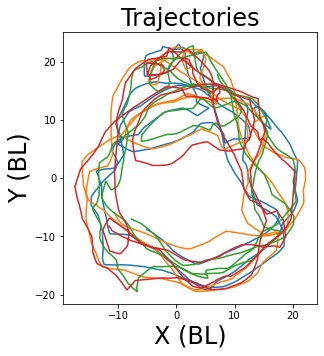

In [14]:
fig, ax_trajectories = plt.subplots(figsize=(5,5))
time_range= (0, 60) # SET HERE THE RANGE IN SECONDS FOR WHICH YOU WANT TO PLOT THE POSITIONS
frame_range = range(time_range[0]*tr.params['frame_rate'], time_range[1]*tr.params['frame_rate'],1) 

for i in range(tr.number_of_individuals):
    ax_trajectories.plot(tr.s[frame_range,i,0], tr.s[frame_range,i,1])
    ax_trajectories.set_aspect('equal','box')
    ax_trajectories.set_title('Trajectories',fontsize=24)
    ax_trajectories.set_xlabel('X (BL)',fontsize=24)
    ax_trajectories.set_ylabel('Y (BL)',fontsize=24)

### Distance to origin, speed, acceleration and curvature

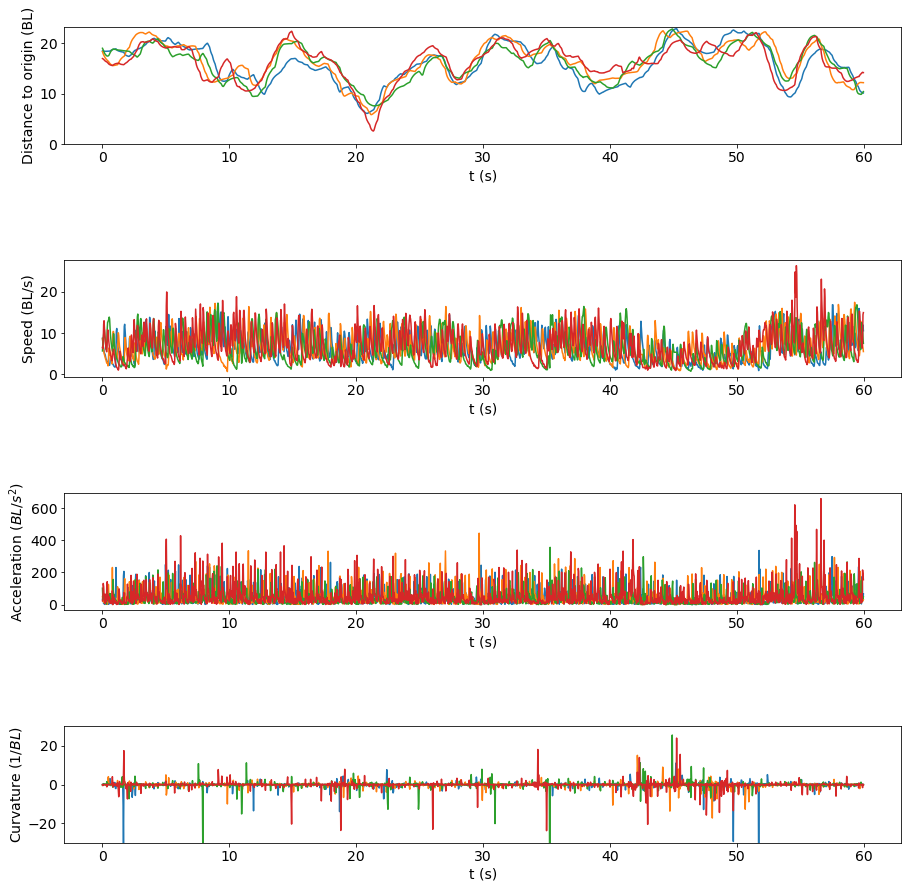

In [15]:
fig, ax = plt.subplots(4,figsize=(15,15))
time_range= (0, 60) # SET HERE THE RANGE IN SECONDS FOR WHICH YOU WANT TO PLOT THE VARIABLES
frame_range = range(time_range[0]*tr.params['frame_rate'], time_range[1]*tr.params['frame_rate'],1) 

for focal in range(tr.number_of_individuals):
    ax[0].plot(np.asarray(frame_range)/tr.params['frame_rate'],tr.distance_to_origin[frame_range, focal])
    ax[1].plot(np.asarray(frame_range)/tr.params['frame_rate'],tr.speed[frame_range, focal])
    ax[2].plot(np.asarray(frame_range)/tr.params['frame_rate'],tr.acceleration[frame_range, focal])
    ax[3].plot(np.asarray(frame_range)/tr.params['frame_rate'],tr.curvature[frame_range, focal])
    plt.subplots_adjust(hspace = 1.)

ax[0].set_xlabel('t (s)',fontsize=14)
ax[0].set_ylabel('Distance to origin (BL)',fontsize=14)
ax[0].tick_params(labelsize=14)
ax[0].set_ylim((0,np.nanmax(tr.distance_to_origin)))

ax[1].set_xlabel('t (s)',fontsize=14)
ax[1].set_ylabel('Speed (BL/s)',fontsize=14)
ax[1].tick_params(labelsize=14)

ax[2].set_xlabel('t (s)',fontsize=14)
ax[2].set_ylabel(r'Acceleration ($BL/s^2$)',fontsize=14)
ax[2].tick_params(labelsize=14)

ax[3].set_xlabel('t (s)',fontsize=14)
ax[3].set_ylabel(r'Curvature ($1/BL$)',fontsize=14)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim((-30,30));


## Smoothing effects

Depending on the frame rate and the resolution at which the video was recorded the trajectories can have different amounts of noise. To obtain more realistic trajectories and to prevent weird effects due to the noise (for example when computing the velocity one can apply some smoothing using the *smooth_params* parameter when loading the traejctories. However high values of the *sigma* parameter can result on unrealistic trajectories and hence affect the results of our analysis. 

Here we plot the positions, velocities and accelerations for different amounts of smoothing. Mind this parameter when loading your trajectories so that a too high smoothing does not affect your results.



In [16]:
sigma_values = [0, 0.5, 1, 2]
tr_smoothing = [tt.Trajectories.from_idtrackerai(trajectories_file_path, 
                                                 smooth_params={'sigma': sigma}).normalise_by('body length')
                for sigma in sigma_values]
[tr.new_time_unit(tr.params['frame_rate'], 'seconds') for tr in tr_smoothing];

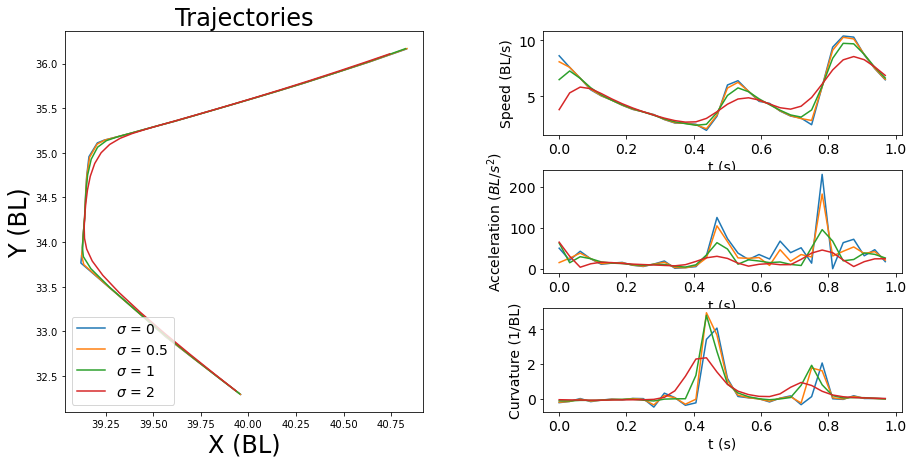

In [17]:
fig = plt.figure(figsize=(15,7))
ax_tr = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=6)
ax_speed = plt.subplot2grid((6, 4), (0, 2), rowspan=2, colspan=4)
ax_accl = plt.subplot2grid((6, 4), (2, 2), rowspan=2, colspan=4)
ax_curv = plt.subplot2grid((6, 4), (4, 2), rowspan=2, colspan=4)
plt.subplots_adjust(hspace=1., wspace=1.)

# Select only the first 60 seconds for plotting
time_range = (0, 1) # range of 
frame_rate = tr.params['frame_rate']
frame_range = range(int(time_range[0]*frame_rate), int(time_range[1]*frame_rate), 1)

focal = 1
for i, (tr_, sigma) in enumerate(zip(tr_smoothing, sigma_values)):
    ax_tr.plot(tr_.s[frame_range, focal,0], tr_.s[frame_range, focal,1], label=r'$\sigma$ = {}'.format(sigma))
    ax_speed.plot(np.asarray(frame_range)/frame_rate, tr_.speed[frame_range, focal])
    ax_accl.plot(np.asarray(frame_range)/frame_rate, tr_.acceleration[frame_range, focal])
    ax_curv.plot(np.asarray(frame_range)/frame_rate, tr_.curvature[frame_range, focal])
    
ax_tr.legend(fontsize=14, loc=3)
ax_tr.set_title('Trajectories',fontsize=24)
ax_tr.set_xlabel('X (BL)',fontsize=24)
ax_tr.set_ylabel('Y (BL)',fontsize=24)

ax_speed.set_xlabel('t (s)',fontsize=14)
ax_speed.set_ylabel('Speed (BL/s)',fontsize=14)
ax_speed.tick_params(labelsize=14)

ax_accl.set_xlabel('t (s)',fontsize=14)
ax_accl.set_ylabel(r'Acceleration ($BL/s^2$)',fontsize=14)
ax_accl.tick_params(labelsize=14)

ax_curv.set_xlabel('t (s)',fontsize=14)
ax_curv.set_ylabel(r'Curvature (1/BL)',fontsize=14)
ax_curv.tick_params(labelsize=14)